In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
car=pd.read_csv('Quikr cars.csv')

In [3]:
car.head()

,Name,Price,Kms_driven,Fuel_type,Year,Company
0,Ford Figo Duratec Petrol EXI 1.2 - 2015,"3,80,000","35,056 kms",Petrol,2015,Ford
1,Maruti Suzuki Wagon R VXI BS IV - 2016,"4,65,000","44,000 kms",Petrol,2016,Maruti
2,Hyundai Creta 1.6 SX PLUS AUTO PETROL - 2018,"13,50,000","42,917 kms",Petrol,2018,Hyundai
3,Hyundai Venue - 2019,"10,19,699","16,112 kms",Petrol,2019,Hyundai
4,Honda Jazz - 2017,"7,13,499","30,988 kms",Petrol,2017,Honda


In [4]:
car.shape

(1032, 6)

In [5]:
car['Fuel_type'].unique()

array(['Petrol', 'Diesel', 'Electric', 'CNG', 'LPG', 'Hybrid'],
      dtype=object)

In [6]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1032 non-null   object
 1   Price       1032 non-null   object
 2   Kms_driven  1032 non-null   object
 3   Fuel_type   1032 non-null   object
 4   Year        1032 non-null   int64 
 5   Company     1032 non-null   object
dtypes: int64(1), object(5)
memory usage: 48.5+ KB


# Data Cleaning 

In [7]:
#Year is in int64. Change to int32.
car['Year']=car['Year'].astype(int)

In [8]:
#Price has Ask for Price
car=car[car['Price']!='Ask For Price']

In [9]:
#Price has commas in its prices and is in object
car['Price']=car['Price'].str.replace(',','').astype(int)

In [10]:
#Kms_driven has object values with kms at last.
car['Kms_driven']=car['Kms_driven'].str.split().str.get(0).str.replace(',','')

In [11]:
car=car[car['Kms_driven'].str.isnumeric()]

In [12]:
car['Kms_driven']=car['Kms_driven'].astype(int)

In [13]:
car.shape

(1026, 6)

In [14]:
#Company does not need any cleaning now. Changing car names. Keeping only the first three words
car['Name']=car['Name'].str.split().str.slice(start=0,stop=3).str.join(' ')

In [15]:
#Resetting the index of the final cleaned data
car=car.reset_index(drop=True)

In [16]:
car.head()

,Name,Price,Kms_driven,Fuel_type,Year,Company
0,Ford Figo Duratec,380000,35056,Petrol,2015,Ford
1,Maruti Suzuki Wagon,465000,44000,Petrol,2016,Maruti
2,Hyundai Creta 1.6,1350000,42917,Petrol,2018,Hyundai
3,Hyundai Venue -,1019699,16112,Petrol,2019,Hyundai
4,Honda Jazz -,713499,30988,Petrol,2017,Honda


In [17]:
car.to_csv('CleaneCar_data.csv')

In [18]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1026 non-null   object
 1   Price       1026 non-null   int32 
 2   Kms_driven  1026 non-null   int32 
 3   Fuel_type   1026 non-null   object
 4   Year        1026 non-null   int32 
 5   Company     1026 non-null   object
dtypes: int32(3), object(3)
memory usage: 36.2+ KB


# Extracting Training Data

In [20]:
X=car[['Name','Company','Year','Kms_driven','Fuel_type']]
y=car['Price']

In [21]:
X

,Name,Company,Year,Kms_driven,Fuel_type
0,Ford Figo Duratec,Ford,2015,35056,Petrol
1,Maruti Suzuki Wagon,Maruti,2016,44000,Petrol
2,Hyundai Creta 1.6,Hyundai,2018,42917,Petrol
3,Hyundai Venue -,Hyundai,2019,16112,Petrol
4,Honda Jazz -,Honda,2017,30988,Petrol
...,...,...,...,...,...
1021,Hyundai i10 Magna,Hyundai,2014,65000,Petrol
1022,Maruti Suzuki Alto,Maruti,2014,60000,Petrol
1023,Jeep Compass Limited,Jeep,2017,31000,Diesel
1024,Jeep Compass Limited,Jeep,2017,31000,Diesel


In [22]:
y

0        380000
1        465000
2       1350000
3       1019699
4        713499
         ...   
1021     229000
1022     275000
1023    1750000
1024    1750000
1025    1750000
Name: Price, Length: 1026, dtype: int32

# Train Test Split

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
#Creating an OneHotEncoder object to contain all the possible categories
ohe=OneHotEncoder()
ohe.fit(car[['Fuel_type','Name','Company']])

OneHotEncoder()

In [28]:
ohe.categories_

[array(['CNG', 'Diesel', 'Electric', 'Hybrid', 'LPG', 'Petrol'],
       dtype=object),
 array(['Audi Q3 -', 'Audi Q5 2.0', 'Audi Q7 3.0', 'Audi Q7 35',
        'BMW 3 Series', 'BMW 5 Series', 'BMW X5 xDrive30d',
        'Chevrolet Aveo -', 'Chevrolet Beat -', 'Chevrolet Beat LS',
        'Chevrolet Beat LT', 'Chevrolet Cruze LTZ', 'Chevrolet Optra -',
        'Chevrolet Sail 1.2', 'Chevrolet Spark -', 'Datsun GO T',
        'Datsun Redi GO', 'Fiat Linea Dynamic', 'Fiat Linea Emotion',
        'Fiat Punto Emotion', 'Ford EcoSport -', 'Ford EcoSport Ambiente',
        'Ford EcoSport Titanium', 'Ford EcoSport Trend', 'Ford Ecosport -',
        'Ford Ecosport 1.0', 'Ford Endeavor 4X4', 'Ford Figo -',
        'Ford Figo 1.5', 'Ford Figo Aspire', 'Ford Figo Diesel',
        'Ford Figo Duratec', 'Ford Freestyle -', 'Ford Freestyle TITANIUM',
        'Ford Ikon -', 'Honda Accord 2.4', 'Honda Amaze -',
        'Honda Amaze 1.2', 'Honda Amaze 1.5', 'Honda BRV -',
        'Honda Brio -', 'Honda B

In [29]:
#Creating a column transformer to transform categorical columns
column_trans=make_column_transformer((OneHotEncoder(categories=ohe.categories_),['Fuel_type','Name','Company']),
                                    remainder='passthrough')
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories=[array(['CNG', 'Diesel', 'Electric', 'Hybrid', 'LPG', 'Petrol'],
      dtype=object),
                                                           array(['Audi Q3 -', 'Audi Q5 2.0', 'Audi Q7 3.0', 'Audi Q7 35',
       'BMW 3 Series', 'BMW 5 Series', 'BMW X5 xDrive30d',
       'Chevrolet Aveo -', 'Chevrolet Beat -', 'Chevrolet Beat LS',
       'Chevrolet Beat LT', 'Chevrolet Cruz...
       'Volkswagen Vento -', 'Volkswagen Vento Highline', 'Volvo XC60 D3',
       'Volvo XC90 D5'], dtype=object),
                                                           array(['Audi', 'BMW', 'Chevrolet', 'Datsun', 'Fiat', 'Ford', 'Honda',
       'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Land', 'MG', 'Mahindra',
       'Maruti', 'Mercedes', 'Nissan', 'Porsche', 'Renault', 'Skoda',
       'Ssangyong', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'], dtype=object)]),
                                 ['Fuel_type', 'Name', 'Company'])])

In [30]:
#Linear Regression Model
lr=LinearRegression()

In [31]:
#Making a pipeline of column_trans & lr
pipe=make_pipeline(column_trans,lr)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['CNG', 'Diesel', 'Electric', 'Hybrid', 'LPG', 'Petrol'],
      dtype=object),
                                                                            array(['Audi Q3 -', 'Audi Q5 2.0', 'Audi Q7 3.0', 'Audi Q7 35',
       'BMW 3 Series', 'BMW 5 Series', 'BMW X5 xDrive30d',
       'Chevrolet Aveo -', 'Chevrolet Beat -', 'Chevrolet Bea...
       'Volkswagen Vento -', 'Volkswagen Vento Highline', 'Volvo XC60 D3',
       'Volvo XC90 D5'], dtype=object),
                                                                            array(['Audi', 'BMW', 'Chevrolet', 'Datsun', 'Fiat', 'Ford', 'Honda',
       'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Land', 'MG', 'Mahindra',
       'Maruti', 'Mercedes', 'Nissan', 'Porsche', 'Renault', 'Skoda',
       'Ssangyong', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'], dtype=object)]),
                                                  ['Fuel_type', 'Name',
                                                   'Company'])])),
                ('linearregression', LinearRegression())])

In [32]:
#Fitting the model
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['CNG', 'Diesel', 'Electric', 'Hybrid', 'LPG', 'Petrol'],
      dtype=object),
                                                                            array(['Audi Q3 -', 'Audi Q5 2.0', 'Audi Q7 3.0', 'Audi Q7 35',
       'BMW 3 Series', 'BMW 5 Series', 'BMW X5 xDrive30d',
       'Chevrolet Aveo -', 'Chevrolet Beat -', 'Chevrolet Bea...
       'Volkswagen Vento -', 'Volkswagen Vento Highline', 'Volvo XC60 D3',
       'Volvo XC90 D5'], dtype=object),
                                                                            array(['Audi', 'BMW', 'Chevrolet', 'Datsun', 'Fiat', 'Ford', 'Honda',
       'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Land', 'MG', 'Mahindra',
       'Maruti', 'Mercedes', 'Nissan', 'Porsche', 'Renault', 'Skoda',
       'Ssangyong', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'], dtype=object)]),
                                                  ['Fuel_type', 'Name',
                                                   'Company'])])),
                ('linearregression', LinearRegression())])

In [33]:
#prediction on X_test
y_pred=pipe.predict(X_test)
y_pred.shape

(206,)

In [34]:
#Checking R2 Score
r2_score(y_test,y_pred)

0.7272619850030119

In [35]:
#Finding the model with a random state of TrainTestSplit where the model was found to give almost 0.91 as r2_score
scores=[]
for i in range(1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=i)
    lr=LinearRegression()
    pipe=make_pipeline(column_trans,lr)
    pipe.fit(X_train,y_train)
    y_pred=pipe.predict(X_test)
    scores.append(r2_score(y_test,y_pred))

In [36]:
np.argmax(scores)

787

In [37]:
scores[np.argmax(scores)]

0.8426500391428224

In [38]:
#The best model is found at a certain random state
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=np.argmax(scores))
lr=LinearRegression()
pipe=make_pipeline(column_trans,lr)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test) 

In [39]:
r2_score(y_test,y_pred)

0.8426500391428224

In [40]:
from sklearn.metrics import mean_squared_error

# Predictions
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

# Calculate training and testing errors
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f"Training Error: {train_error}")
print(f"Testing Error: {test_error}")

Training Error: 72857460754.11234
Testing Error: 39711535198.31063


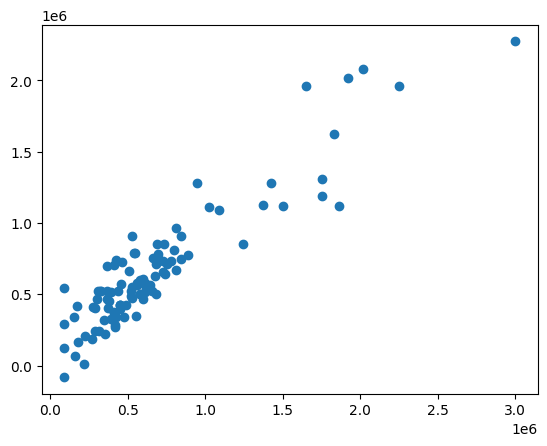

In [41]:
## plot a scatter plot for the prediction
plt.scatter(y_test,y_pred)

In [42]:
## Residuals
residuals=y_test-y_pred

In [43]:
residuals

936     -5554.668964
823     57093.523722
304    205617.684416
531     27466.911049
223     66162.292374
           ...      
862     85530.238958
920     43250.884117
421    -32026.114965
365    135230.266179
842     88006.711116
Name: Price, Length: 103, dtype: float64

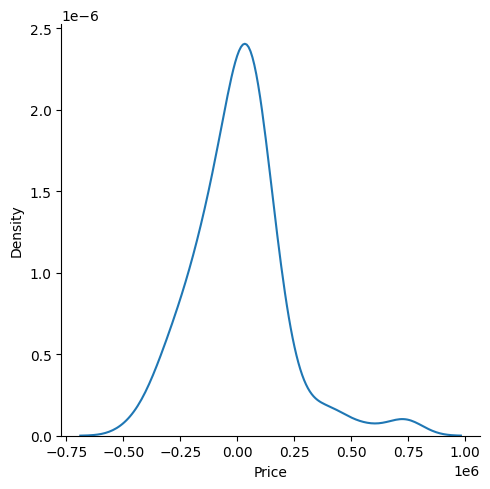

In [44]:
## Plot this residuals 
import seaborn as sns
sns.displot(residuals,kind="kde")

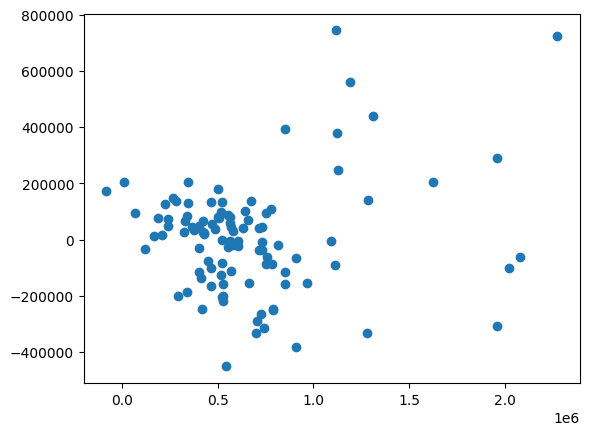

In [45]:
## Scatter plot with respect to prediction and residuals
## uniform distribution
plt.scatter(y_pred,residuals)

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

142115.62174361642
39711535198.31063
199277.5330997216


In [47]:
from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred)
print(score)

0.8426500391428224


In [48]:
#display adjusted R-squared
1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.8345392164182257

In [49]:
 pipe.predict(pd.DataFrame(columns=X_test.columns,data=np.array(['Maruti Suzuki Swift','Maruti',2019,100,'Petrol']).reshape(1,5)))

array([721573.497482])

In [50]:
X_test

,Name,Company,Year,Kms_driven,Fuel_type
936,Maruti Suzuki Celerio,Maruti,2019,5817,Petrol
823,Maruti Suzuki Baleno,Maruti,2017,42893,Petrol
304,Kia Seltos GTX,Kia,2020,19500,Petrol
531,Maruti Suzuki Swift,Maruti,2014,28979,Petrol
223,Maruti Suzuki Swift,Maruti,2014,21610,Petrol
...,...,...,...,...,...
862,Renault Kwid -,Renault,2017,15883,Petrol
920,Maruti Suzuki Swift,Maruti,2013,61717,Petrol
421,Maruti Suzuki Omni,Maruti,2008,85000,Petrol
365,Hyundai Elite i20,Hyundai,2016,74913,Petrol


In [51]:
y_pred

array([ 562953.66896363,  562505.47627848, 1625382.31558357,
        423932.08895065,  423236.70762576,  561738.28260615,
        471179.15811278,  500164.83054054,  741155.38226451,
       1961408.16094846, 1115023.15407208,  580414.45949392,
        -82689.74749301,  375666.28584667,  291089.32438512,
       1093603.8534905 ,  267583.26694125, 1283722.92112041,
        209820.19167808,  789130.98332661,  399279.73173869,
       1309628.81886023,  521518.82957938, 1120253.84271944,
        656124.13473174,  519825.99728706,  187604.15480137,
        702325.99257559,  724022.87424749, 1190111.55749173,
        240208.69801317,  343763.38066018,  606135.71018554,
        665253.69658548,  631534.89664745, 2274979.83528645,
        337444.84202927,  813016.99267672,  730869.81824274,
        502469.33689623,  515867.12543233,  602939.08144502,
        789855.03983559, 2080844.603186  , 1120811.76169212,
        466375.33275619,  517921.89675954,  849818.0036975 ,
        524855.34147543,

In [52]:
pipe.predict(pd.DataFrame(columns=X_test.columns,data=np.array(['Maruti Suzuki Baleno','Maruti',2016,48329,'Petrol']).reshape(1,5)))

array([502945.12908514])

In [54]:
import pickle
#open a file, where we want to store the data
regmodel = open('regmodel.pkl', 'wb')

# dump information to that file
pickle.dump(pipe, regmodel)

In [55]:
pipe.predict(pd.DataFrame(columns=['Name','Company','Year','Kms_driven','Fuel_type'],data=np.array(['Maruti Suzuki Swift','Maruti',2019,100,'Petrol']).reshape(1,5)))


array([721573.497482])